# INF8111 - Predicting the demand of a Bike Sharing System - LAB2

### Team ZMS
* Sofien Ben Ayed   - 1971009
* Zhuofei Kang      - 1939634
* Maryam El Arfaoui - 1939476

In [78]:
#### IMPORTING LIBRARIES

import numpy as np
import pandas as pd
import datetime, random

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Clustering
from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline

# Sampling
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor

# Evaluating
from sklearn.metrics import f1_score, precision_recall_fscore_support, classification_report, make_scorer, confusion_matrix
from sklearn.model_selection import GridSearchCV

## Exploring the data

In [79]:
data = pd.read_csv("training.csv")
data.head(10)

,Date/Hour,Temperature (°C),Drew point (°C),Relativite humidity (%),wind direction (10s deg),Wind speed (km/h),Visibility (km),Visility indicator,Pressure at the station (kPa),hmdx,Wind Chill,Weather,Public Holiday,Station Code,Withdrawals,Volume
0,2015-06-29 11:00,"17,6","11,5",67.0,31.0,13.0,"24,1",NaN,"100,53",NaN,NaN,ND,0,6178,3,0
1,2015-07-14 00:00,"22,5","20,1",86.0,17.0,10.0,"24,1",NaN,"100,15",30.0,NaN,ND,0,6921,1,0
2,2015-09-30 16:00,"12,1","3,1",54.0,1.0,34.0,"24,1",NaN,"101,59",NaN,NaN,Nuageux,0,6219,0,0
3,2015-06-06 14:00,"18,5","0,7",30.0,30.0,12.0,"48,3",NaN,"101,54",NaN,NaN,ND,0,6196,11,1
4,2016-06-10 04:00,"8,9","4,9",76.0,29.0,9.0,"24,1",NaN,"100,93",NaN,NaN,Généralement nuageux,0,6087,0,0
5,2016-08-28 00:00,"21,3","14,3",64.0,18.0,12.0,"24,1",NaN,"101,88",25.0,NaN,ND,0,6068,0,0
6,2016-04-24 02:00,"1,3","-11,2",39.0,36.0,16.0,"24,1",NaN,"101,58",NaN,NaN,ND,0,6424,0,0
7,2016-07-24 09:00,"20,3","11,4",56.0,30.0,7.0,"48,3",NaN,"101,26",NaN,NaN,ND,0,6039,2,0
8,2015-08-28 00:00,"15,3","12,3",82.0,28.0,9.0,"24,1",NaN,"101,52",NaN,NaN,ND,0,6088,1,0
9,2015-10-27 12:00,"8,8","-0,2",53.0,21.0,18.0,"48,3",NaN,"103,04",NaN,NaN,ND,0,6009,0,0


In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1546454 entries, 0 to 1546453
Data columns (total 16 columns):
Date/Hour                        1546454 non-null object
Temperature (°C)                 1545362 non-null object
Drew point (°C)                  1545362 non-null object
Relativite humidity (%)          1545362 non-null float64
wind direction (10s deg)         1544270 non-null float64
Wind speed (km/h)                1545362 non-null float64
Visibility (km)                  1545362 non-null object
Visility indicator               0 non-null float64
Pressure at the station (kPa)    1545362 non-null object
hmdx                             495768 non-null float64
Wind Chill                       9646 non-null float64
Weather                          1545362 non-null object
Public Holiday                   1546454 non-null int64
Station Code                     1546454 non-null int64
Withdrawals                      1546454 non-null int64
Volume                           154645

In [81]:
data["hmdx"].isna().sum()/len(data)

0.6794162645639638

In [82]:
data["Wind Chill"].isna().sum()/len(data)

0.9937625044133224

In [83]:
data.describe()

,Relativite humidity (%),wind direction (10s deg),Wind speed (km/h),Visility indicator,hmdx,Wind Chill,Public Holiday,Station Code,Withdrawals,Volume
count,1.545362e+06,1.544270e+06,1.545362e+06,0.0,495768.000000,9646.000000,1.546454e+06,1.546454e+06,1.546454e+06,1.546454e+06
mean,6.527641e+01,2.016335e+01,1.603086e+01,NaN,29.593612,-4.433962,2.542074e-02,6.236956e+03,2.675098e+00,7.064161e-02
std,1.828176e+01,9.499484e+00,8.162366e+00,NaN,3.567742,1.947614,1.573993e-01,3.490283e+02,3.820694e+00,2.562253e-01
min,1.100000e+01,0.000000e+00,0.000000e+00,NaN,25.000000,-9.000000,0.000000e+00,6.008000e+03,0.000000e+00,0.000000e+00
25%,5.200000e+01,1.500000e+01,1.000000e+01,NaN,27.000000,-6.000000,0.000000e+00,6.078000e+03,0.000000e+00,0.000000e+00
50%,6.600000e+01,2.200000e+01,1.500000e+01,NaN,29.000000,-4.000000,0.000000e+00,6.171500e+03,1.000000e+00,0.000000e+00
75%,8.000000e+01,2.700000e+01,2.100000e+01,NaN,32.000000,-3.000000,0.000000e+00,6.235000e+03,4.000000e+00,0.000000e+00
max,9.900000e+01,3.600000e+01,5.300000e+01,NaN,43.000000,-1.000000,1.000000e+00,1.000200e+04,1.790000e+02,1.000000e+00


In [84]:
(data["Weather"].value_counts()/len(data))

ND                                             0.601389
Généralement nuageux                           0.105449
Généralement dégagé                            0.082382
Dégagé                                         0.058256
Nuageux                                        0.056020
Pluie                                          0.035660
Averses de pluie                               0.032129
Pluie,Brouillard                               0.009650
Bruine,Brouillard                              0.003648
Brouillard                                     0.003413
Orages,Averses de pluie                        0.002118
Bruine                                         0.002118
Pluie modérée,Brouillard                       0.001177
Averses de pluie modérées                      0.001059
Pluie modérée                                  0.000706
Averses de neige                               0.000588
Orages                                         0.000588
Averses de pluie,Brouillard                    0

In [85]:
%matplotlib inline
cov = data.cov()
print(cov)

                          Relativite humidity (%)  wind direction (10s deg)  \
Relativite humidity (%)              3.342228e+02             -6.230887e+00   
wind direction (10s deg)            -6.230887e+00              9.024020e+01   
Wind speed (km/h)                   -2.374368e+01              3.537447e-01   
Visility indicator                            NaN                       NaN   
hmdx                                -2.273653e+00             -7.854284e-01   
Wind Chill                          -1.009005e+00             -1.815781e-02   
Public Holiday                      -5.119596e-02              3.119826e-02   
Station Code                        -1.707829e-13              1.290247e-13   
Withdrawals                         -2.055559e+01              1.513163e+00   
Volume                              -7.811317e-01              6.074896e-02   

                          Wind speed (km/h)  Visility indicator          hmdx  \
Relativite humidity (%)       -2.374368e+01      

Text(0.5, 1.0, 'Total number of Withdrawals by hour')

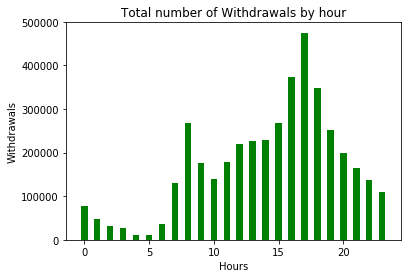

In [104]:
def getHour(d):
    dateHour = d.split()
    #date = dateHour[0].split("-")
    if dateHour[1][1] == ':':
        hour = int(dateHour[1][0:1])
    else:
        hour = int(dateHour[1][0:2])
    return hour

def getWeekDay(d):
    dateHour=d.split()
    date = dateHour[0].split("-")
    year = int(date[0])
    month = int(date[1])
    day = int(date[2])
    hour = int(dateHour[1][0:2])
    
    date = datetime.date(year, month, day)
    weekday = date.weekday()
    
    return weekday

def getMonth(d):
    dateHour=d.split()
    date = dateHour[0].split("-")
    month = int(date[1])
    return month

data_hour = data.copy()
data_hour["Date/Hour"] = data["Date/Hour"].apply(getHour) #for withdrawals by day or by month replace respectively by getDay or getMonth
data_hour.head(20)
arrayH = np.array(data_hour["Date/Hour"])
arrayW = np.array(data_hour["Withdrawals"])
dicHours = {}

for i in range(len(data_hour)):
    h = arrayH[i]
    w = arrayW[i]
    if h in dicHours:
        dicHours[h] += int(w)
    else:
        dicHours[h] = int(w)
days =["Mon", "Tues", "Wed", "Sat","Fri", "Sun", "Thur"] 
Months=["Ju", "Jul", "Sep", "Aug", "Ap", "Oct", "May", "Nov"]

## to show the total number of Withdrawals by hour
plt.bar(dicHours.keys(), dicHours.values(), width=0.5, color='g')
plt.xlabel("Hours")
plt.ylabel("Withdrawals")
plt.title("Total number of Withdrawals by hour")

## to show the total number of Withdrawals by day of the week
#plt.bar(dicHours.keys(), dicHours.values(), width=0.5, color='g',tick_label=days)
#plt.xlabel("Days of the week")
#plt.ylabel("Withdrawals")
#plt.title("Total number of Withdrawals by day of the week")

## to show the total number of Withdrawals by Month
#plt.bar(dicHours.keys(), dicHours.values(), width=0.5, color='g',tick_label=Months)
#plt.xlabel("Months")
#plt.ylabel("Withdrawals")
#plt.title("Total number of Withdrawals by Month")


## Preprocessing the data

### Date

From a date with the format "2015-06-29 11:00", we extract 6 features :
* Year : 2015
* Day of the week : 0 (Monday). Sunday would be 6.
* Month_Cos : $cos(month*\frac{2*\Pi}{12})$. Months go from 0 to 11.
* Month_Sin : $sin(month*\frac{2*\Pi}{12})$. 
* Hour_Cos : $cos(month*\frac{2*\Pi}{24})$. Hours go from 0 to 23.
* Hour_Sin : $sin(month*\frac{2*\Pi}{24})$. 

In [88]:
# Extract 6 features from a date string
def processDate(d):
    
    dateHour = d.split()
    date = dateHour[0].split("-")

    year = int(date[0])
    month = int(date[1])
    day = int(date[2])
    hour = int(dateHour[1][0:2])
    
    date = datetime.date(year, month, day)
    
    # Monday = 0, Tuesday = 1, ..., Sunday = 6
    weekday = date.weekday()
    
    # Transformations to deal with circularity
    hour_sin = np.sin(hour*(2.*np.pi/24))
    hour_cos = np.cos(hour*(2.*np.pi/24))
    month_sin = np.sin((month-1)*(2.*np.pi/12))
    month_cos = np.cos((month-1)*(2.*np.pi/12))
    
    return year, month_sin, month_cos, weekday, hour, hour_cos
print(processDate("2015-06-29 23:00"))

(2015, 0.5000000000000003, -0.8660254037844385, 0, 23, 0.9659258262890681)


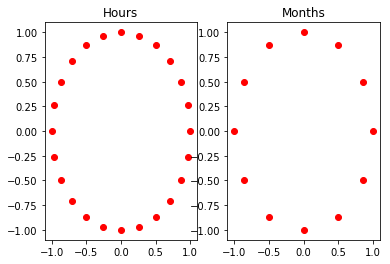

In [89]:
#### SHOWING THE RESULT OF THE TRANSFORMATIONS OF HOURS AND MONTHS

hours_sin = np.sin(np.array(range(0,24))*(2.*np.pi/24))
hours_cos = np.cos(np.array(range(0,24))*(2.*np.pi/24))
months_sin = np.sin((np.array(range(1,13))-1)*(2.*np.pi/12))
months_cos = np.cos((np.array(range(1,13))-1)*(2.*np.pi/12))

plt.figure(1)

plt.subplot(121)
plt.plot(hours_sin, hours_cos, "ro")
plt.title("Hours")

plt.subplot(122)
plt.plot(months_sin, months_cos, "ro")
plt.title("Months")

plt.show()

In [90]:
#### HELPERS TO DEAL WITH DATES

# Transform dates of the data to datetime format  
def getDateTime(date):
    
    dateHour = date.split()
    onlyDate = dateHour[0].split("-")
    
    year = int(onlyDate[0])
    month = int(onlyDate[1])
    day = int(onlyDate[2])
    hour = int(dateHour[1][0:2])
    
    dateTime = datetime.datetime(year, month, day, hour)
    
    return dateTime

# Find the index of the nearest date to the pivot date 
def nearest_ind(items, pivot):

    mini = float("inf")
    i = 0
    
    for j, date in enumerate(items):
        t = abs(date - pivot).total_seconds()
        
        if t < mini:
            i = j
            mini = t
            
        # Less than one day is enough
        if t < 86400:
            i = j
            break
            
    return i

### Numerical values

* String representing float with "," -> Float
* String representing integers -> Int
* For the few missing values, we put np.nan

In [91]:
# From string with "," to float
def processFloatFeature(t, i, feature):
    if isinstance(t, str):
        value = float(t.replace(",","."))
    else:
        value = np.nan
    return value

# From string to integer
def processIntFeature(t, i, feature):
    if str(t) != "nan": 
        value = int(t)
    else: 
        value = np.nan
    return value

### Weather

The different types of weathers are gathered in only 7 categories :
* Nuageux : {Nuageux, Généralement Nuageux}
* Dégagé : {Dégagé, Généralement Dégagé}
* Pluie : {Pluie, Averses de pluie, Pluie modérée, Averses de pluie modérée}
* Pluie forte : {Pluie forte, Averses de pluie forte}
* Brouillard : {Brouillard, Bruine}
* Orages : {Orages}
* Neige : {Neige, Averses de neige}

If the value of the weather for an entry is "ND", we look for the nearest entry in time with a value of weather which is not missing and impute by this value.

We finally encode the result as a One-Hot vector.

In [92]:
def processWeather(w, i, data, sorted_data):
    
    weatherTypes = ["Nuageux", "Dégagé", "Pluie", "Brouillard", "Orages", "Pluie forte", "Neige"]
    #weatherTypes = ["Nuageux", "Dégagé", "Pluie", "Brouillard", "Orages", "Pluie forte", "Neige", "Généralement nuageux", "Généralement dégagé", "Averses de pluie", "Averses de pluie modérées", "Bruine", "Averses de pluie forte", "Pluie modérée", "Averses de neige"]
    
    if w == "ND" or not isinstance(w, str):
        weathers = None
        n_to_try = 2
        
        # Try to find a near entry (in time) with a Weather value 
        for j in range(i+1, min(i + n_to_try, len(data))):
            test = data["Weather"].iloc[j]
            if test != "ND" and isinstance(test, str):
                weathers = test.split(",")
                break
        
        if weathers == None:
            return [0] * len(weatherTypes)
        
    else:
        weathers = w.split(",")
    
    weatherTypesDic = {"Généralement nuageux": "Nuageux", "Nuageux": "Nuageux",
                    "Généralement dégagé": "Dégagé", "Dégagé": "Dégagé", 
                    "Pluie": "Pluie", "Averses de pluie": "Pluie", 
                    "Averses de pluie modérées": "Pluie", "Pluie modérée": "Pluie",
                    "Neige": "Neige", "Averses de neige": "Neige",
                    "Brouillard": "Brouillard", "Bruine": "Brouillard",
                    "Orages": "Orages", 
                    "Averses de pluie forte": "Pluie forte", "Pluie forte": "Pluie forte"}
    
    weatherVector = [0] * len(weatherTypes)
    
    for weather in weathers:
        weatherVector[weatherTypes.index(weatherTypesDic[weather])] = 1

    return weatherVector

In [93]:
# We do not add Wind Chill and Visibility Indicator

### Combining Temperature, Drew Point and Wind Speed

Meteorologists have created different indexes in order to grasp the feeling of hot and cold. These indexes can be more informative than using raws temperatures.  
We calculate two of them :
* The humidex which is an index used by Canadian meteorologists to describe how hot the weather feels to the average person. It is calculated using the air temperature and the drew point.
$$H = T_\text{air} + 0.5555 \left[6.11 e^{5417.7530 \left(\frac{1}{273.16} - \frac{1}{273.15+T_\text{dew}}\right)} - 10\right]$$
* The windchill is the lowering of body temperature due to the passing-flow of lower-temperature air. It is calculated using the air temperature and the wind speed.
$$T_\mathrm{wc}=13.12 + 0.6215 T_\mathrm{air}-11.37 v^{+0.16} + 0.3965 T_\mathrm{air} v^{+0.16}$$

Wind chill numbers are always lower than the air temperature for values where the formula is valid. When the apparent temperature is higher than the air temperature, the heat index is used instead.

These indexes replace Temperature and Drew Point.

### Adding the position of BIXI stations

In [94]:
# The data comes from : https://montreal.bixi.com/en/open-data
stations = pd.read_csv("Stations.csv")
stations.head()

,code,name,latitude,longitude
0,6315,Lacombe / de la Côte-des-Neiges,45.496851,-73.623320
1,6019,Berri / Sherbrooke,45.517910,-73.567143
2,6347,Métro St-Michel (Shaughnessy / St-Michel),45.559199,-73.599658
3,6219,de l'Hôtel-de-Ville / Roy,45.517333,-73.574436
4,6211,Roy / St-Laurent,45.515610,-73.575690


Latitude and longitude are not taken as they are. We first transform it to get cartesian coordinates :
* $x = R.cos(latitude).sin(longitude)$
* $y = R.cos(latitude)$
* $z = R.sin(latitude)$

R should be the Earth radius but we use $R = 1$ as we don't need the real coordinates but just the positions between the stations.

In [95]:
#### TRANSFORMING LATITUDE AND LONGITUDE IN CARTESIAN COORDINATES
stations2 = stations.copy()

lat = []
lon = []

for i in range(len(stations)):
    lat.append(stations.iloc[i]["latitude"])
    lon.append(stations.iloc[i]["longitude"])

x = np.cos(lat) * np.cos(lon)
y = np.cos(lat) * np.sin(lon)
z = np.sin(lat)

# Preparing the dataframe for clustering
stations2 = pd.concat([stations2, pd.Series(x, name="x")], axis=1)
stations2 = pd.concat([stations2, pd.Series(y, name="y")], axis=1)
stations2 = pd.concat([stations2, pd.Series(z, name="z")], axis=1)
stations2 = stations2.drop(columns=["latitude", "longitude", "name", "code"])

stations2.head()

,x,y,z
0,-0.011394,0.055046,0.998419
1,-0.009053,0.033991,0.999381
2,0.001379,-0.005948,0.999981
3,-0.008949,0.034615,0.999361
4,-0.009334,0.036294,0.999298


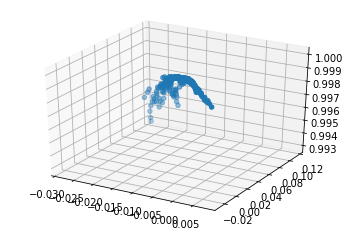

In [96]:
#### PLOTTING THE RESULT OF THE TRANSFORMATIONIN 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)

We now want to make clusters of BIXI stations using their positions.  
For that, we use K-means on the cartesian coordinates.

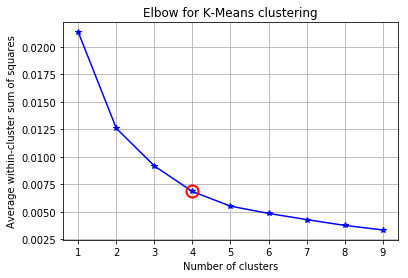

In [97]:
##(IEEE reference format) : P. Dangeti, A. Yu, C. Chung, A. Yim, et T. Petrou, Numerical Computing with Python: Harness
##the power of Python to analyze and find hidden patterns in the data. Packt Publishing, 2018.

#### TRYING TO FIND THE RIGHT NUMBER OF CLUSTERS
# Numbers of clusters to try
K = range(1,10)

# Apply kmeans 1 to 10
KM = [kmeans(stations2,k) for k in K]

# Cluster centroids
centroids = [cent for (cent,var) in KM]

D_k = [cdist(stations2, cent, 'euclidean') for cent in centroids]

cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/stations2.shape[0] for d in dist]  

# Plot elbow curve
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[3], avgWithinSS[3], marker='o', markersize=12,markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')

plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
tt = plt.title('Elbow for K-Means clustering')  

In [98]:
#### APPLYING KMEANS CLUSTERING

km = KMeans(4, init='k-means++')
km.fit(stations2)

# Classify the stations into four clusters
clusters = km.predict(stations2) 
stations = pd.concat([stations, pd.Series(clusters, name="Cluster")], axis=1)

# Each station is now affected to a cluster number
stationsDic = {}
for i, station in enumerate(stations["code"]):
    stationsDic[station] = stations.iloc[i]["Cluster"]
    
stations.head()

,code,name,latitude,longitude,Cluster
0,6315,Lacombe / de la Côte-des-Neiges,45.496851,-73.623320,2
1,6019,Berri / Sherbrooke,45.517910,-73.567143,3
2,6347,Métro St-Michel (Shaughnessy / St-Michel),45.559199,-73.599658,0
3,6219,de l'Hôtel-de-Ville / Roy,45.517333,-73.574436,3
4,6211,Roy / St-Laurent,45.515610,-73.575690,3


### Full preprocessing pipeline

The 5 following features are not processed neither used in the models :
* hmdx -> Not relevant
* wind direction (10s deg) -> Not relevant
* Pressure at the station (kPa) -> Not relevant
* Visility indicator -> Too many missing values (more than 99%)
* Wind Chill -> Too many missing values so redo each calculation as explained previously

=> The features *Year*, *Station Code* and *Cluster* are One-Hot encoded.  
=> The features *Wind speed (km/h)*, *Visibility (km)*, *Relativite humidity (%)*, *Calculated Humidex*, *Calculated Wind Chill* are standardized by removing the mean and scaling to unit variance. The missing values are imputed by the mean value.

In [99]:
#### FULL PREPROCESSING OF THE DATA
def preprocessData(data):

    processedData = pd.DataFrame()
    processedData['Year'], processedData['MonthSin'], processedData['MonthCos'], processedData['Weekday'], processedData['HourSin'], processedData['HourCos'] = zip(*data['Date/Hour'].map(processDate))
    processedData["Temperature (°C)"] = [processFloatFeature(t, i, "Temperature (°C)") for i, t in enumerate(data["Temperature (°C)"])]
    processedData["Drew point (°C)"] = [processFloatFeature(t, i, "Drew point (°C)") for i, t in enumerate(data["Drew point (°C)"])]
    processedData["Visibility (km)"] = [processFloatFeature(t, i, "Visibility (km)") for i, t in enumerate(data["Visibility (km)"])]
    processedData["Relativite humidity (%)"] = [processIntFeature(t, i, "Relativite humidity (%)") for i, t in enumerate(data["Relativite humidity (%)"])]
    processedData["Wind speed (km/h)"] = [processIntFeature(t, i, "Wind speed (km/h)") for i, t in enumerate(data["Wind speed (km/h)"])]
    
    # Sort the data by date in order to easilly impute missing weather values
    sorted_data = data.copy()
    sorted_data["Date/Hour2"] = data["Date/Hour"].apply(getDateTime)
    sorted_data = sorted_data.sort_values(by="Date/Hour2")
    sorted_data = sorted_data.drop(columns=["Date/Hour2"], axis=1)
    
    processedWeathers = [processWeather(w, i, data, sorted_data) for i, w in enumerate(data["Weather"])]
    processedData["Nuageux"],processedData["Dégagé"],processedData["Pluie"],processedData["Brouillard"],processedData["Orages"],processedData["Pluie forte"],processedData["Neige"] = zip(*processedWeathers)
    #processedData["Nuageux"],processedData["Dégagé"],processedData["Pluie"],processedData["Brouillard"],processedData["Orages"],processedData["Pluie forte"],processedData["Neige"],processedData["Généralement nuageux"], processedData["Généralement dégagé"], processedData["Averses de pluie"], processedData["Averses de pluie modérées"], processedData["Bruine"], processedData["Averses de pluie forte"], processedData["Pluie modérée"], processedData["Averses de neige"] = zip(*processedWeathers)
    processedData["Public Holiday"] = data["Public Holiday"]
    processedData["Station Code"] = data["Station Code"]
    
    # Joining the cluster number for each station
    clus = []
    for s in data["Station Code"]:
        clus.append(stationsDic[s])
    processedData = pd.concat([processedData, pd.Series(clus, name="Cluster")], axis=1)
    
    # Calculating Wind Chill and Humidex
    froid_ressenti = []     # Wind Chill
    chaleur_ressentie = []  # Humidex
    for i, temperature in enumerate(processedData["Temperature (°C)"]):
        
        froid = float(temperature)
        chaud = float(temperature)
        
        if temperature != np.nan:
            p = processedData.iloc[i]
            
            wind = p["Wind speed (km/h)"]
            if wind != np.nan:
                if temperature < 10 and wind > 4.8:
                    froid = 13.12 + 0.6215 * temperature + (0.3965 * temperature - 11.37) * (wind ** 0.16)
                if temperature < 10 and wind <= 4.8:
                    froid = temperature + 0.2 * (0.1345 * temperature - 1.59) * wind
            
            drew = p["Drew point (°C)"]
            if drew != np.nan:
                chaud = temperature + 0.5555 * (6.11 * 2.71828 ** (5417.7530 * ((1/273.16) - 1/(273.15 + drew))) - 10)
        
        froid_ressenti.append(froid)
        chaleur_ressentie.append(chaud)
    
    processedData = pd.concat([processedData, pd.Series(froid_ressenti, name="Froid ressenti")], axis=1)
    processedData = pd.concat([processedData, pd.Series(chaleur_ressentie, name="Chaleur ressentie")], axis=1)
    
    # Wind Chill and Humidex replace Temperature and Drew Point
    processedData.drop(columns=["Temperature (°C)"], inplace=True)
    processedData.drop(columns=["Drew point (°C)"], inplace=True)
    
    return processedData

# Full pipeline of preprocessing
def full_process(train_data, test_data):
    
    train = preprocessData(train_data)
    test = preprocessData(test_data)
    
    pipeline1 = Pipeline([
        ("scaler", StandardScaler()),
        ("fillna", SimpleImputer(strategy = "mean"))
    ])

    preprocess = make_column_transformer(
        (["Wind speed (km/h)", "Visibility (km)", "Relativite humidity (%)", "Froid ressenti", "Chaleur ressentie"], pipeline1),
        (["Year", "Station Code", "Weekday", "Cluster"], OneHotEncoder(categories = 'auto', sparse = True)),
        remainder='passthrough'
    )

    train = preprocess.fit_transform(train)
    test = preprocess.transform(test)
    
    return train, test

## Modelling

### Dealing with unbalancement

80% of the data will be used for training and 20% for validation.  
As the classes (Volume) are unbalanced (ratio 1:14), we use a stratified split.  
Moreover, we upsampled the minority class (1) for better predictions of our models.  

In [100]:
# Split the data : 80% for training and 20% for validation
train_data, test_data = train_test_split(data, test_size=0.2, random_state=55, stratify=data["Volume"])
train_data, test_data = train_data.reset_index(drop = True), test_data.reset_index(drop = True)

# Separate majority and minority classes
train_data_majority = train_data[train_data["Volume"]==0]
train_data_minority = train_data[train_data["Volume"]==1]

# Upsample minority class
train_data_minority_upsampled = resample(train_data_minority, 
                                 replace=True,
                                 n_samples=int(len(train_data_majority)/5),
                                 random_state=58)
 
# Combine majority class with upsampled minority class
train_data = pd.concat([train_data_majority, train_data_minority_upsampled])
train_data = train_data.reset_index(drop = True)

# Display new class counts
train_data["Volume"].value_counts()

# Preprocessing the data
X_train, X_test = full_process(train_data.iloc[:,:-2], test_data.iloc[:,:-2])

# Binary Volume
y_train_volume = train_data.iloc[:,-1]
y_test_volume = test_data.iloc[:,-1]

# Number of Withdrawals
y_train_withdraw = train_data.iloc[:,-2]
y_test_withdraw = test_data.iloc[:,-2]

C:\Users\maryanna\AppData\Roaming\Python\Python36\site-packages\sklearn\compose\_column_transformer.py:732: DeprecationWarning: `make_column_transformer` now expects (transformer, columns) as input tuples instead of (columns, transformer). This has been introduced in v0.20.1. `make_column_transformer` will stop accepting the deprecated (columns, transformer) order in v0.22.
  warnings.warn(message, DeprecationWarning)


### Different types of modelling

Two paths were taken in order to tackle the problem :
* Binary classification - Direct prediction of the volume : low or high
* Regression - Prediction of the value of withdrawals and then conclude about the volume given a threshold

For binary classification, three algorithms were tested :
* Logistic Regression
* Random Forest
* Multi-Layer Perceptron

Regression was only tested with Multi-Layer Perceptron as it obtained far better results than the others.

In [101]:
models = ["Logistic Regression", "Random Forest", "Multi-Layer Perceptron Classifier", "Multi-Layer Perceptron Regressor"]

logistic = LogisticRegression()
random_forest = RandomForestClassifier(verbose=3, max_depth=50)
mlp_classifier = MLPClassifier(max_iter=20, verbose=True, solver="adam", activation="relu", hidden_layer_sizes=(100,50))
mlp_regressor = MLPRegressor(max_iter=10, verbose=True, solver="adam", activation="relu", hidden_layer_sizes=(100,50))

# logistic = MLPClassifier(max_iter=1, verbose=True, solver="adam", activation="relu", hidden_layer_sizes=(20,))
# random_forest = MLPClassifier(max_iter=1, verbose=True, solver="adam", activation="relu", hidden_layer_sizes=(20,))
# mlp_classifier = MLPClassifier(max_iter=1, verbose=True, solver="adam", activation="relu", hidden_layer_sizes=(20,))
# mlp_regressor = MLPClassifier(max_iter=1, verbose=True, solver="adam", activation="relu", hidden_layer_sizes=(20,))

logistic.fit(X_train, y_train_volume)
random_forest.fit(X_train, y_train_volume)
mlp_classifier.fit(X_train, y_train_volume)
mlp_regressor.fit(X_train, y_train_withdraw)

# Making the prediction
predictions = []
predictions.append(logistic.predict(X_test))
predictions.append(random_forest.predict(X_test))
predictions.append(mlp_classifier.predict(X_test))

# Threshold to determine if the Volume is low or high given the number of Withdrawals
threshold = 8

# Get the binary classification from the withdrawals prediction
pred_regressor = mlp_regressor.predict(X_test)
final_pred_regressor = np.zeros(len(pred_regressor))
for i in range(len(pred_regressor)):
    if pred_regressor[i] > threshold:
        final_pred_regressor[i] = 1

predictions.append(final_pred_regressor)

C:\Users\maryanna\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\maryanna\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.5min remaining:    0.0s


building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 18.7min finished


Iteration 1, loss = 0.23464251
Iteration 2, loss = 0.20795372
Iteration 3, loss = 0.20276446
Iteration 4, loss = 0.19945305
Iteration 5, loss = 0.19672494
Iteration 6, loss = 0.19446995
Iteration 7, loss = 0.19272090
Iteration 8, loss = 0.19120281
Iteration 9, loss = 0.18968157
Iteration 10, loss = 0.18856019
Iteration 11, loss = 0.18740283
Iteration 12, loss = 0.18644424
Iteration 13, loss = 0.18557925
Iteration 14, loss = 0.18486577
Iteration 15, loss = 0.18411030
Iteration 16, loss = 0.18332648
Iteration 17, loss = 0.18284527
Iteration 18, loss = 0.18224122
Iteration 19, loss = 0.18177318
Iteration 20, loss = 0.18124930


C:\Users\maryanna\AppData\Roaming\Python\Python36\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 4.80317969
Iteration 2, loss = 3.83982226
Iteration 3, loss = 3.69725725
Iteration 4, loss = 3.62099862
Iteration 5, loss = 3.56518733
Iteration 6, loss = 3.52179891
Iteration 7, loss = 3.47965052
Iteration 8, loss = 3.44699025
Iteration 9, loss = 3.42172813
Iteration 10, loss = 3.39973792


C:\Users\maryanna\AppData\Roaming\Python\Python36\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.3s finished


In [102]:
#### EVALUATION METRICS
print("============ F1 Score ============")
for i in range(len(models)):
    y_pred = predictions[i]
    name = models[i]
    print(name + " : ", f1_score(y_test_volume, y_pred, average='binary'))

print("\n============ Complete Classification Report ============")
for i in range(len(models)):
    y_pred = predictions[i]
    name = models[i]
    print("## " + name)
    print(classification_report(y_test_volume, y_pred))

print("\n============ Confusion Matrix ============") 
for i in range(len(models)):
    y_pred = predictions[i]
    name = models[i]
    print("## " + name)
    print(pd.DataFrame(confusion_matrix(y_test_volume, y_pred)))

============ F1 Score ============
Logistic Regression :  0.39597430197620737
Random Forest :  0.511058131277265
Multi-Layer Perceptron Classifier :  0.5915622992935132
Multi-Layer Perceptron Regressor :  0.6051782682512734

============ Complete Classification Report ============
## Logistic Regression
              precision    recall  f1-score   support

           0       0.95      0.96      0.96    287442
           1       0.42      0.37      0.40     21849

   micro avg       0.92      0.92      0.92    309291
   macro avg       0.69      0.67      0.68    309291
weighted avg       0.92      0.92      0.92    309291

## Random Forest
              precision    recall  f1-score   support

           0       0.96      0.97      0.97    287442
           1       0.57      0.46      0.51     21849

   micro avg       0.94      0.94      0.94    309291
   macro avg       0.77      0.72      0.74    309291
weighted avg       0.93      0.94      0.93    309291

## Multi-Layer Perceptro

### Tuning the hyperparameters

We are interested here in tuning the hyperparameters of the multi-layer perceptron :  
* The number of layers
* The number of neurons per layer
* The activation function 
About the solver, we've chosen the stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy BaAdam (*Adam*) as it's known to work well on relatively large datasets as our.

Through cross-validation with 3 fits, we searched for the best parameters. 

In [416]:
#### PREPARING THE DATA FOR THE GRIDSEARCH CROSS VALIDATION
train_data = data.copy()
train_data = train_data.reset_index(drop = True)

train_data_majority, train_data_minority = train_data[train_data["Volume"]==0], train_data[train_data["Volume"]==1]

# Upsample minority class
train_data_minority_upsampled = resample(train_data_minority, replace=True, n_samples=int(len(train_data_majority)/5), random_state=123)

# Combine majority class with upsampled minority class
train_data = pd.concat([train_data_majority, train_data_minority_upsampled])
train_data = train_data.reset_index(drop = True)

kaggle = pd.read_csv("test.csv")
test_kaggle = kaggle.copy()
test_kaggle = test_kaggle.reset_index(drop = True)

# Preprocessing the data
X_train, X_test = full_process(train_data.iloc[:,:-2], test_kaggle)
y_train = train_data.iloc[:,-1]

In [371]:
#### GRIDSEARCH CROSS VALIDATION

mlp = MLPClassifier(max_iter=10, verbose=True, solver="adam")

# Defining the evaluating function : F1-score for the positive class
f1_scorer = make_scorer(f1_score, average='binary', pos_label=True)

# Trying with different architectures and activation functions
parameter_space = {
    'hidden_layer_sizes': [(100,50,50),(50,50,50),(50,100,50),(100,),(200,),(200,100),(100,50),(50,100),(100,100),(50,50)],
    'activation': ['logistic', 'tanh', 'relu']
}

# Running a GridSearch Cross Validation with 3 fits
clf = GridSearchCV(mlp, parameter_space, scoring=f1_scorer, cv=3, verbose=3)
clf.fit(X_train, y_train_volume)

# Best parameters set
print('Best parameters found:\n', clf.best_params_)

# All results with means and stds
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

### Last test : Kaggle submission

For the Kaggle submission, our best model was trained over all the training dataset.

In [394]:
# We train the model over all the data
train_data = data.copy()
train_data = train_data.reset_index(drop = True)

# Kaggle test retrieval
kaggle = pd.read_csv("test.csv")
test_kaggle = kaggle.copy()
test_kaggle = test_kaggle.reset_index(drop = True)

train_data_majority = train_data[train_data["Volume"]==0]
train_data_minority = train_data[train_data["Volume"]==1]

# Upsample minority class
train_data_minority_upsampled = resample(train_data_minority, 
                                 replace=True,
                                 n_samples=int(len(train_data_majority)/5),
                                 random_state=13)
 
# Combine majority class with upsampled minority class
train_data = pd.concat([train_data_majority, train_data_minority_upsampled])
train_data = train_data.reset_index(drop = True)

# Processing the data
X_train, X_test = full_process(train_data.iloc[:,:-2], test_kaggle)
y_train_withdraw = train_data.iloc[:,-2]

# The best model found previously
clf = MLPRegressor(max_iter=10, verbose=True, solver="adam", activation="relu", hidden_layer_sizes=(100,50))

#clf.fit(X_train, y_train_volume)
clf.fit(X_train, y_train_withdraw)

# Making the prediction
y_pred = clf.predict(X_test)

# Get the binary classification from the withdrawals prediction
y_pred2 = np.zeros(len(y_pred))
for i in range(len(y_pred)):
    if y_pred[i] > 8.5:
        y_pred2[i] = 1

In [241]:
#### CREATING THE FILE FOR KAGGLE SUBMISSION

f = open("submission.csv", "w")
f.write("id,volume")
f.write("\n")

for i in range(len(y_pred2)):
    dateHour = test_kaggle["Date/Hour"][i].split()
    station = test_kaggle["Station Code"][i]
    if y_pred2[i] == 1:
        volume = "True"
    else:
        volume = "False"
    f.write(dateHour[0] + "_" + dateHour[1] + "_" + str(station) + "," + volume + "\n")
    
f.close()

#### Our final score : 0.57192